<a href="https://colab.research.google.com/github/seungkyoon/Projects/blob/master/Bong_Seungkyoon_ps3_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PSET 3
*CPSC 453: Unsupervised Learning*

*Seungkyoon Bong*

In [10]:
from google.colab import drive, files
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/ColabNotebooks/
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/code')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [17]:
from ps3_functions import *
from vae import VAE

## 2 MNIST Classification

### 2.1 Downloading MNIST

In [ ]:
import torch
from torchvision import datasets, transforms

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

mnist_train = datasets.MNIST(root = 'data', train=True, download=True, transform = transforms.ToTensor())
mnist_test = datasets.MNIST(root = 'data', train=False, download=True,transform = transforms.ToTensor())

batch_size = 128
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle = True)

### 2.2 Logistic Regression

In [ ]:
model = LogisticRegression()
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.5)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/log_reg.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.926966667175293. Test accuracy: 0.9231999516487122
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9321666955947876. Test accuracy: 0.9259999990463257
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9296166896820068. Test accuracy: 0.9214999675750732
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9334666728973389. Test accuracy: 0.924299955368042
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9327666759490967. Test accuracy: 0.924299955368042
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9330833554267883. Test accuracy: 0.9226999878883362
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.93586665391922. Test accuracy: 0.9235999584197998
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9366833567619324. Test accuracy: 0.9235000014305115
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9358833432197571. Test accuracy: 0.9257999658584595
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9327666759490967. Test accuracy: 0.9238999485969543


**Question 2.2.1:** *What percentage classification accuracy did your simple network achieve?*

**Answer:** 


### 2.3 Feed-forward Neural Network

In [ ]:
# Without non-linearity
model = FeedForwardNet()
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_nonlinear.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9136833548545837. Test accuracy: 0.9170999526977539
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9216166734695435. Test accuracy: 0.9210999608039856
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9241333603858948. Test accuracy: 0.9233999848365784
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9265000224113464. Test accuracy: 0.9232999682426453
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9276666641235352. Test accuracy: 0.9235999584197998
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9292833209037781. Test accuracy: 0.9250999689102173
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9298833608627319. Test accuracy: 0.9248999953269958
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9305166602134705. Test accuracy: 0.9259999990463257
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9314166903495789. Test accuracy: 0.9261999726295471
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.931850016117096. Test accuracy: 0.9247999787330627

In [ ]:
# With sigmoid non-linearity before and after
# Likely cripples the model to have a nonlinearity in output (because cross entropy loss already takes softmax)
model = FeedForwardNet(pre_activation = nn.Sigmoid(), post_activation = nn.Sigmoid())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_sigmoid.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.8048833608627319. Test accuracy: 0.8134999871253967
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.836650013923645. Test accuracy: 0.8478999733924866
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.8513666987419128. Test accuracy: 0.8619999885559082
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.8617333173751831. Test accuracy: 0.8700999617576599
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.8689166903495789. Test accuracy: 0.8788999915122986
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.8741333484649658. Test accuracy: 0.8829999566078186
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.8786666989326477. Test accuracy: 0.8873999714851379
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.8823666572570801. Test accuracy: 0.8898999691009521
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.8849499821662903. Test accuracy: 0.8930999636650085
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.8878499865531921. Test accuracy: 0.8948999643325806

In [ ]:
# With sigmoid non-linearity before
model = FeedForwardNet(pre_activation = nn.Sigmoid())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_sigmoid_before.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.8827500343322754. Test accuracy: 0.8914999961853027
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.8986333608627319. Test accuracy: 0.9050999879837036
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9065499901771545. Test accuracy: 0.9114999771118164
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9120833277702332. Test accuracy: 0.9174000024795532
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9163500070571899. Test accuracy: 0.9199000000953674
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9205166697502136. Test accuracy: 0.9238999485969543
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9232500195503235. Test accuracy: 0.9269999861717224
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9263499975204468. Test accuracy: 0.9287999868392944
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9296333193778992. Test accuracy: 0.930899977684021
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9322500228881836. Test accuracy: 0.9333999752998352

In [ ]:
# With ReLU non-linearity before
model = FeedForwardNet(pre_activation = nn.ReLU())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_relu.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9298999905586243. Test accuracy: 0.9315999746322632
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9463500380516052. Test accuracy: 0.9459999799728394
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9550333619117737. Test accuracy: 0.9530999660491943
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9619166851043701. Test accuracy: 0.9581999778747559
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9670166969299316. Test accuracy: 0.9614999890327454
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9704333543777466. Test accuracy: 0.964199960231781
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9734333157539368. Test accuracy: 0.9667999744415283
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9755499958992004. Test accuracy: 0.9685999751091003
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9776333570480347. Test accuracy: 0.9695999622344971
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9796333312988281. Test accuracy: 0.9714999794960022

In [ ]:
# With Softplus non-linearity before
model = FeedForwardNet(pre_activation = nn.Softplus())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_softplus.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9103500247001648. Test accuracy: 0.9124999642372131
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.9207500219345093. Test accuracy: 0.9210000038146973
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.9291333556175232. Test accuracy: 0.9284999966621399
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9354333281517029. Test accuracy: 0.9341999888420105
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9413166642189026. Test accuracy: 0.9391999840736389
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.9469833374023438. Test accuracy: 0.9430999755859375
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9509666562080383. Test accuracy: 0.9475999474525452
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9554499983787537. Test accuracy: 0.9512999653816223
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.958466649055481. Test accuracy: 0.953499972820282
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9616000056266785. Test accuracy: 0.9567999839782715


In [ ]:
# Best activation function (ReLU) non-linearity with smaller hidden size
model = FeedForwardNet(hidden_size = 30, pre_activation = nn.ReLU())
model = model.to(device)
SGD = torch.optim.SGD(model.parameters(), lr = 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, loss_fn, SGD, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ff_narrow.pt')

 EPOCH 10. Progress: 10.0%. 
 Train accuracy: 0.9064666628837585. Test accuracy: 0.906499981880188
 EPOCH 20. Progress: 20.0%. 
 Train accuracy: 0.921999990940094. Test accuracy: 0.9225999712944031
 EPOCH 30. Progress: 30.0%. 
 Train accuracy: 0.931950032711029. Test accuracy: 0.9307000041007996
 EPOCH 40. Progress: 40.0%. 
 Train accuracy: 0.9391999840736389. Test accuracy: 0.9375999569892883
 EPOCH 50. Progress: 50.0%. 
 Train accuracy: 0.9449833631515503. Test accuracy: 0.9434999823570251
 EPOCH 60. Progress: 60.0%. 
 Train accuracy: 0.948983371257782. Test accuracy: 0.9476999640464783
 EPOCH 70. Progress: 70.0%. 
 Train accuracy: 0.9531500339508057. Test accuracy: 0.9517999887466431
 EPOCH 80. Progress: 80.0%. 
 Train accuracy: 0.9565500020980835. Test accuracy: 0.9551999568939209
 EPOCH 90. Progress: 90.0%. 
 Train accuracy: 0.9593833684921265. Test accuracy: 0.9564999938011169
 EPOCH 100. Progress: 100.0%. 
 Train accuracy: 0.9616333246231079. Test accuracy: 0.9592999815940857


**Question 2.3.1:** *What percentage classification accuracy does this more complex network achieve?*

**Answer:** 

**Question 2.3.2:** *Create a plot of the training and test error vs the number of iterations. How many iterations
are sufficient to reach good performance?*

**Answer:** 

**Question 2.3.3:** *Print the confusion matrix showing which digits were misclassified, and what they were misclassified as. What numbers are frequently confused with one another by your model?*

**Answer:** 

**Question 2.3.4:** *Experiment with the learning rate, optimizer and activation function of your network. Report the best accuracy and briefly describe the training scheme that reached this accuracy.*

**Answer:** 


## 3 Autoencoder

### 3.1 MNIST

In [ ]:
def train(model, loss_fn, optimizer, train_loader, test_loader):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    num_epochs = 100 # obviously, this is too many. I don't know what this author was thinking.
    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data, targets in train_loader:

            # run the model on the data
            model_input = torch.reshape(data, (-1, 784)).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            out = model(model_input)

            # Calculate the loss
            loss = loss_fn(out, model_input)

            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()
            optimizer.zero_grad()

        # Give status reports every 5 epochs
        if (epoch + 1) % 5==0:
            print(f" EPOCH {epoch+1}. Progress: {(epoch+1)/num_epochs*100}%. ")
            print(f" Train loss: {evaluate(model,train_loader)}. Test loss: {evaluate(model,test_loader)}")

def evaluate(model, evaluation_set):
    """
    Evaluates the given model on the given dataset.
    Returns the MSE loss of the output and original input
    """
    total_loss = 0
    total_samples = 0
    loss_fn = torch.nn.MSELoss()

    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        # TODO: Fill in the rest of the evaluation function.
        for data, targets in evaluation_set:

            model_input = torch.reshape(data, (-1, 784)).to(device)
            out = model(model_input)

            total_samples += targets.shape[0]
            total_loss += loss_fn(out, model_input)*targets.shape[0]

    mean_loss = 1.0 * total_loss / total_samples
    return mean_loss

In [ ]:
model = Autoencoder(activation = nn.Tanh())
model = model.to(device)
Adam = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = torch.nn.MSELoss()

train(model, loss_fn, Adam, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ae_tanh.pt')

 EPOCH 5. Progress: 5.0%. 
 Train loss: 0.03971928358078003. Test loss: 0.039753977209329605
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.03825227543711662. Test loss: 0.03825204819440842
 EPOCH 15. Progress: 15.0%. 
 Train loss: 0.03697613999247551. Test loss: 0.03711700811982155
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.03632295876741409. Test loss: 0.03646008297801018
 EPOCH 25. Progress: 25.0%. 
 Train loss: 0.035278987139463425. Test loss: 0.03563898056745529
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.03516751900315285. Test loss: 0.03558137267827988
 EPOCH 35. Progress: 35.0%. 
 Train loss: 0.03494458273053169. Test loss: 0.03547857701778412
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.03503577411174774. Test loss: 0.03564044088125229
 EPOCH 45. Progress: 45.0%. 
 Train loss: 0.03483179211616516. Test loss: 0.03520921617746353
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.03463738411664963. Test loss: 0.03501656651496887
 EPOCH 55. Progress: 55.00000000000001%. 
 Train loss: 0.034

In [ ]:
import torchvision.utils
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import scprep

def display_1000(model, out_size = 2, extra_hidden = None, extra_targets = None):
    all_outs = np.empty((0, out_size))
    all_targets = []

    total_displayed = 0
    for data, targets in test_loader:
      model_input = torch.reshape(data, (-1, 784))
      
      if model.__class__.__name__ == "VAE":
          out = model.encode(model_input)[0].detach().numpy()
      else:
          out = model.encode(model_input).detach().numpy()

      all_outs = np.vstack((all_outs, out))
      all_targets.extend(list(map(int, targets)))
      
      total_displayed += targets.shape[0]
      if total_displayed >= 1000:
        break

    outs = all_outs
    if model.__class__.__name__ == "VAE":
        if (extra_hidden is not None and extra_targets is not None):
            all_outs = np.vstack((extra_hidden, all_outs))
        all_outs = scprep.reduce.pca(all_outs, 2)
        
        if (extra_hidden is not None and extra_targets is not None):
            extra_hidden = all_outs[0:3, :]
            outs = all_outs[3:, :]
        else:
            outs = all_outs


    ax = scprep.plot.scatter2d(outs, c = all_targets, legend = True, legend_loc = 'right',
                          figsize=(12, 8), cmap=scprep.plot.colors.tab10_continuous(n_colors=10))
    ax.set_title("Embedding Layer of Autoencoder for 1000 Images")
    
    if extra_hidden is not None and extra_targets is not None:
      ax.scatter(extra_hidden[0:2, 0], extra_hidden[0:2, 1], c=extra_targets, marker='x',
                s=300, cmap=scprep.plot.colors.tab10_continuous(n_colors=10))
      ax.scatter(extra_hidden[2, 0], extra_hidden[2, 1], c='red', marker='x', s=300)
      ax.set_title(f"Plot with Interpolated {extra_targets[0]}-{extra_targets[1]} In Red")
  

def display_10(model):
  total_displayed = [False]*10
  plt.figure(figsize=(20, 4))
  for data, targets in test_loader:
    model_input = torch.reshape(data, (-1, 784))

    if model.__class__.__name__ == "VAE":
        out = model(model_input)[0].detach().numpy()
    else:
        out = model(model_input).detach().numpy()
    out = out.reshape(-1, 28, 28)

    for i, target in enumerate(targets):
      if not total_displayed[target]:
        plt.subplot(2, 10, target + 1)
        plt.axis('off')
        plt.imshow(data[i, :, :].reshape(28, 28), aspect='auto')

        plt.subplot(2, 10, target + 11)
        plt.axis('off')
        plt.imshow(out[i, :, :].reshape(28, 28), aspect='auto')

        total_displayed[target] = True
    
    if not any(total_displayed):
      break
    
  plt.show()

def interpolate(model):
  plt.figure(figsize=(12, 4))
  for data, targets in test_loader:
    if targets[0] == targets[[1]]: continue
    model_input = torch.reshape(data[0:2, :, :], (-1, 784))
    out = model.encode(model_input)
    if model.__class__.__name__ == "VAE":
        mu, logvar = out
    
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.title(f'Original {targets[0]}')
    plt.imshow(data[0, :, :].reshape(28, 28), aspect = 'auto')

    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.title(f'Original {targets[1]}')
    plt.imshow(data[1, :, :].reshape(28, 28), aspect = 'auto')
    
    if model.__class__.__name__ == "VAE":
        mu_mean = mu.mean(dim=0)
        logvar_mean = logvar.mean(dim=0)
        interpolated = model.reparameterize(mu_mean, logvar_mean)
    else:
        interpolated = out.mean(dim=0)

    output = model.decode(interpolated).detach().numpy().reshape(28, 28)
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.title(f'Interpolated {targets[0]}-{targets[1]}')
    plt.imshow(output, aspect = 'auto')

    break

  plt.show()

  targets = [targets[0], targets[1]]
  if model.__class__.__name__ == "VAE":
      out = torch.vstack((mu, mu_mean)).detach().numpy()
  else:
      out = torch.vstack((out, interpolated)).detach().numpy()

  display_1000(model, out_size = out.shape[1], extra_hidden = out, extra_targets = targets)


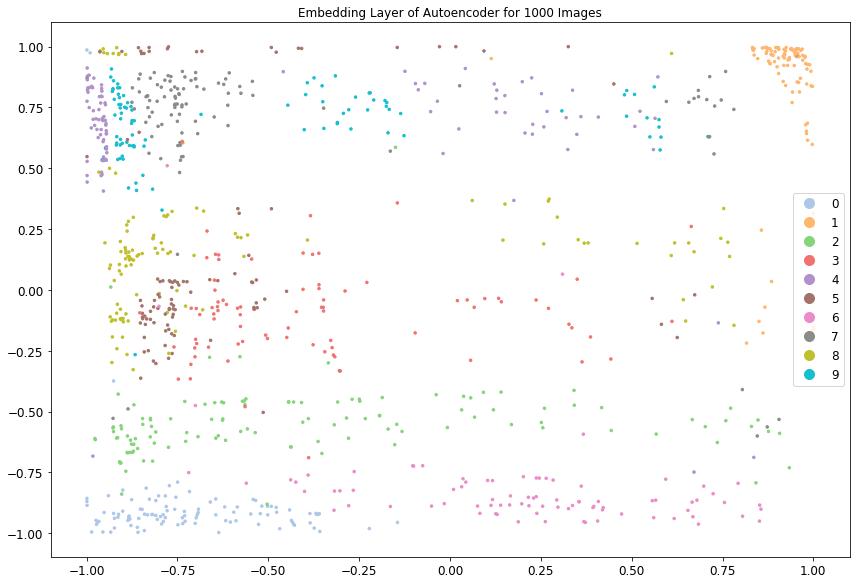

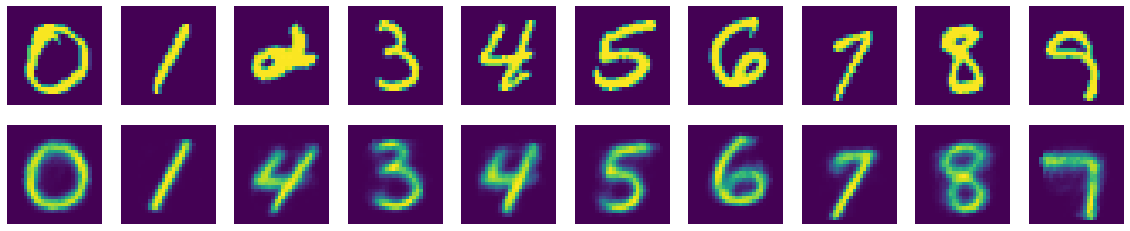

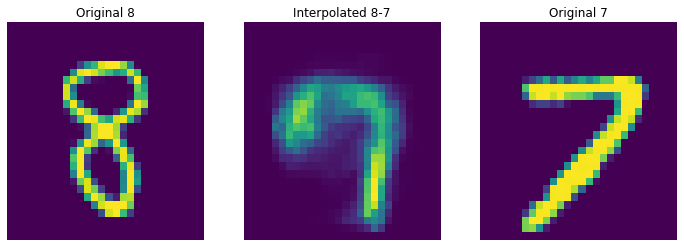

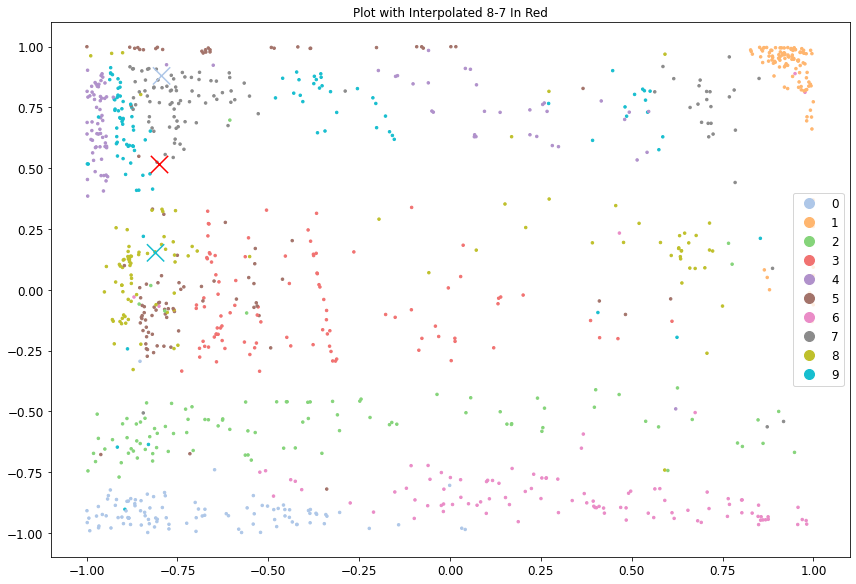

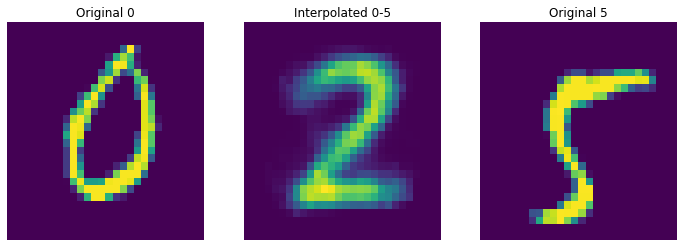

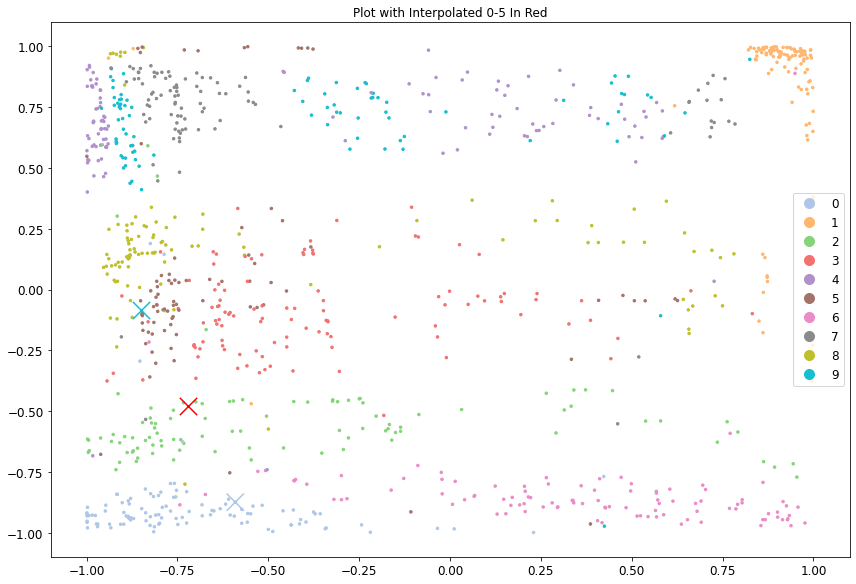

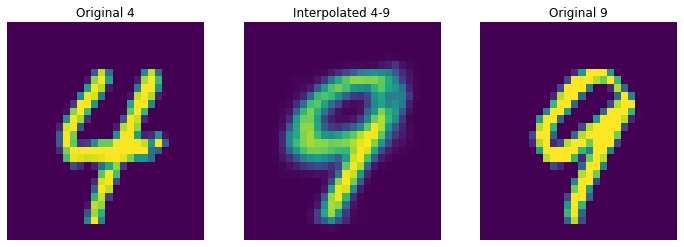

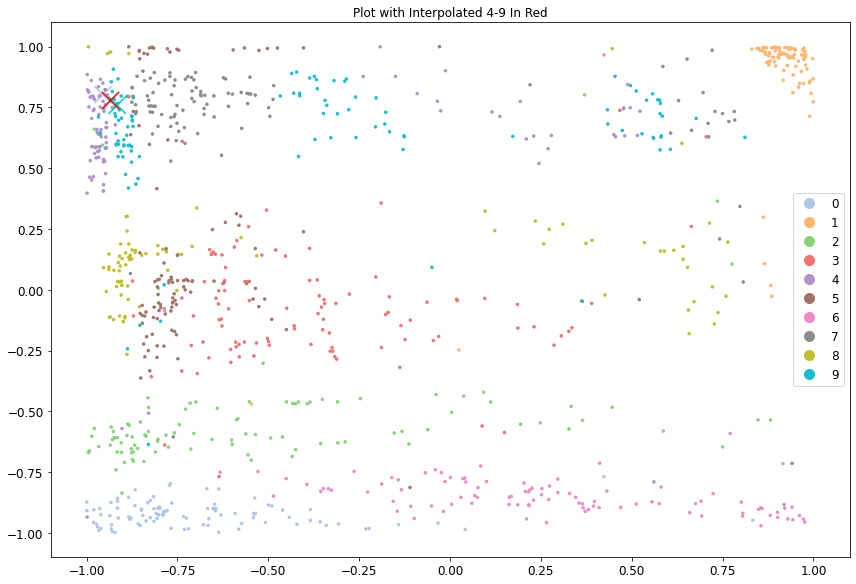

In [ ]:
model = Autoencoder(activation = nn.Tanh())
model.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/ae_tanh.pt'))
model.eval()

display_1000(model)
display_10(model)

for i in range(3):
  interpolate(model)

In [ ]:
model = Autoencoder()
model = model.to(device)
Adam = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = torch.nn.MSELoss()

train(model, loss_fn, Adam, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ae_identity.pt')

 EPOCH 5. Progress: 5.0%. 
 Train loss: 0.03961634635925293. Test loss: 0.0399719662964344
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.036376673728227615. Test loss: 0.037006065249443054
 EPOCH 15. Progress: 15.0%. 
 Train loss: 0.035099174827337265. Test loss: 0.035776104778051376
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.03458607196807861. Test loss: 0.03539487347006798
 EPOCH 25. Progress: 25.0%. 
 Train loss: 0.034379735589027405. Test loss: 0.035191748291254044
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.033789992332458496. Test loss: 0.034768685698509216
 EPOCH 35. Progress: 35.0%. 
 Train loss: 0.033441927284002304. Test loss: 0.03448091819882393
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.032894037663936615. Test loss: 0.03393232822418213
 EPOCH 45. Progress: 45.0%. 
 Train loss: 0.03251643851399422. Test loss: 0.03377606347203255
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.032349176704883575. Test loss: 0.03374491631984711
 EPOCH 55. Progress: 55.00000000000001%. 
 Train los

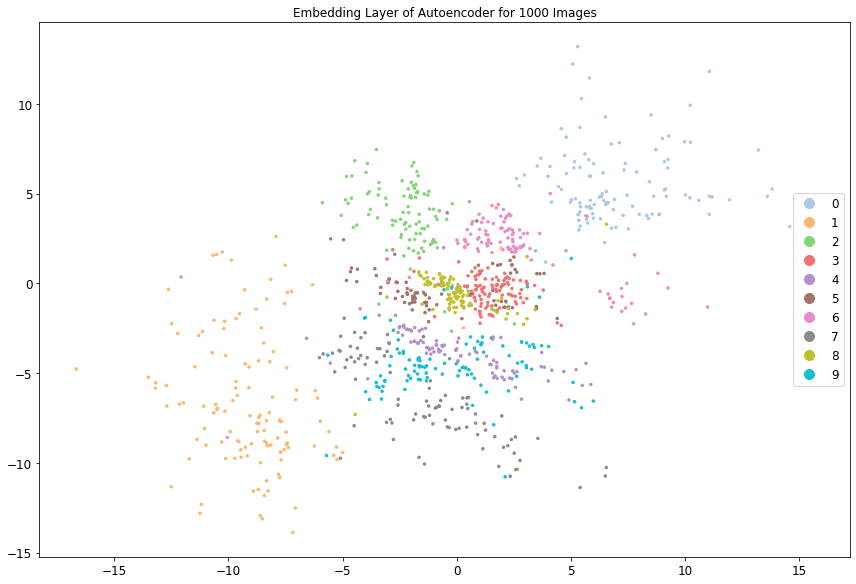

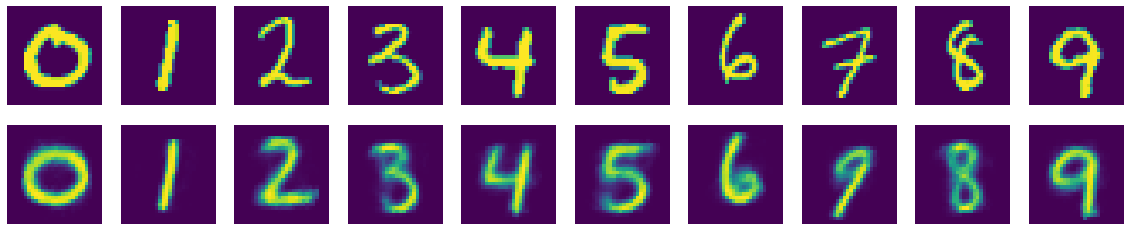

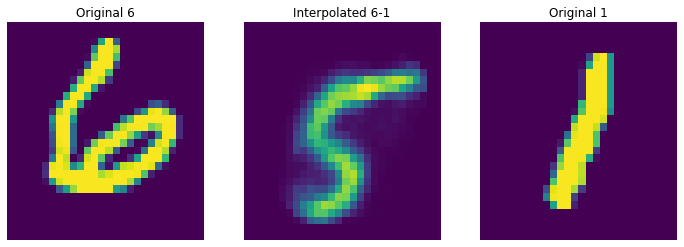

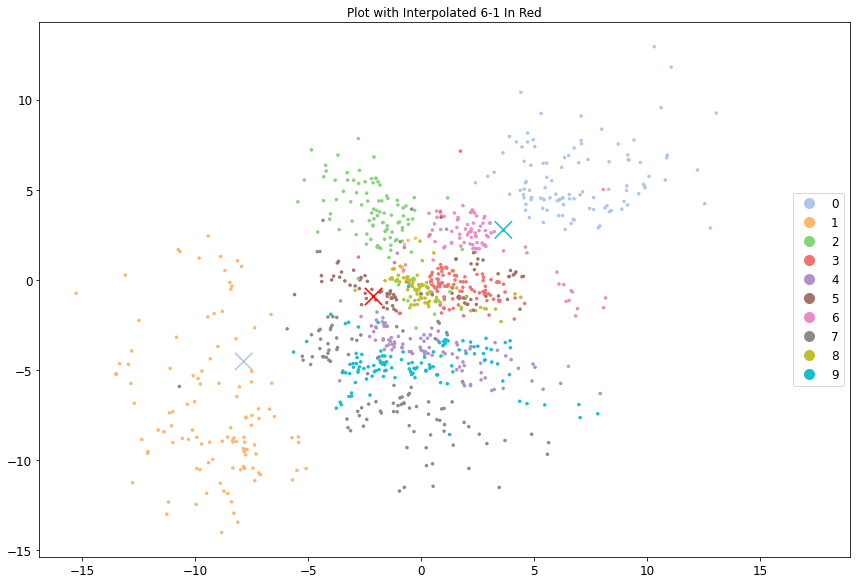

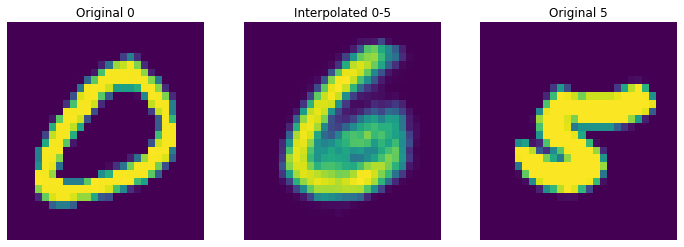

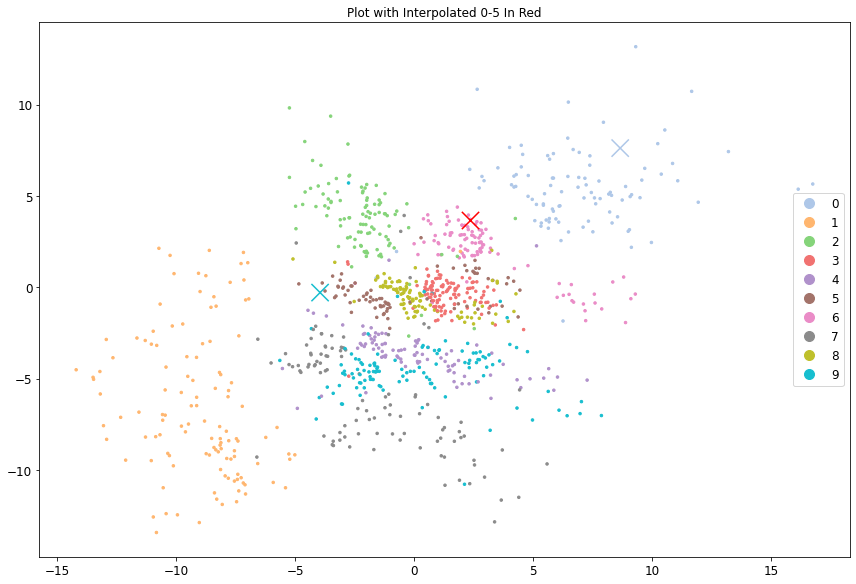

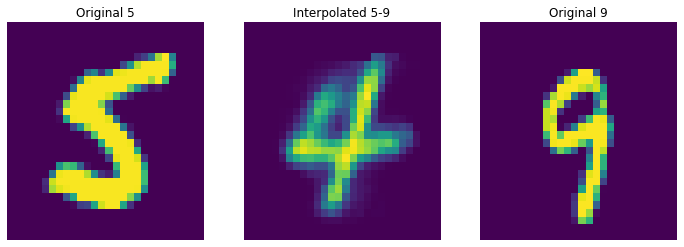

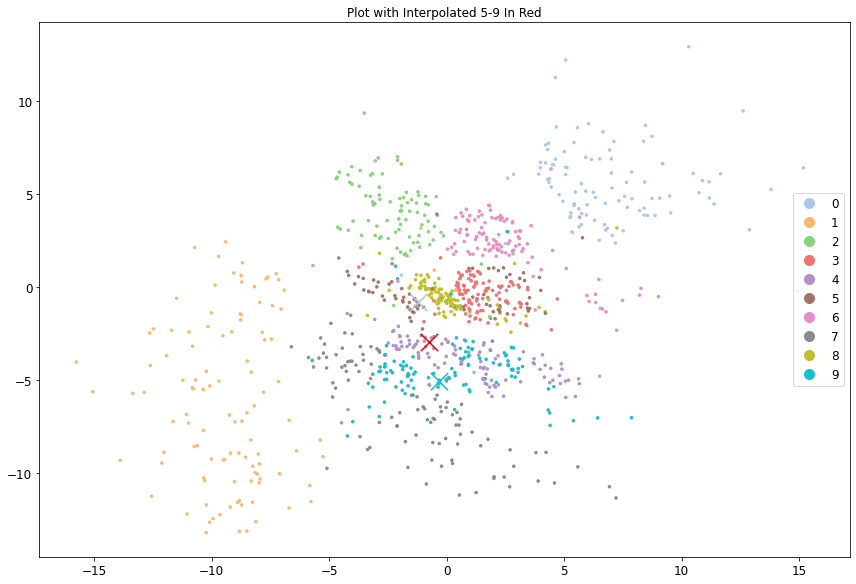

In [ ]:
model = Autoencoder()
model.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/ae_identity.pt'))
model.eval()

display_1000(model)
display_10(model)

for i in range(3):
  interpolate(model)

**Question 3.1.1:** *Do the colors easily separate, or are they all clumped together? Which numbers are frequently embedded close together, and what does this mean?*

**Answer:** 

**Question 3.1.2:** *How realistic were the images you generated by interpolating between points in the latent space? Can you think of a better way to generate images with an autoencoder?*

**Answer:** 


### 3.2 Biological Data: Retinal Bipolar Dataset

In [ ]:
import pandas
from torch.utils.data.sampler import SubsetRandomSampler
data = pandas.read_pickle('/content/drive/MyDrive/ColabNotebooks/data/retinal-bipolar-data.pickle')
metadata = pandas.read_pickle('/content/drive/MyDrive/ColabNotebooks/data/retinal-bipolar-metadata.pickle')
data_pca = scprep.reduce.pca(data, 1024)

data_sub, metadata_sub = scprep.select.subsample(data_pca, metadata, n=3000, seed=1)
data_sub = np.array(data_sub)
metadata_sub = np.array(metadata_sub)

nrows = data_sub.shape[0]
size = nrows//5
indices = list(range(nrows))
np.random.seed(453)
np.random.shuffle(indices)
train_indices, val_indices = indices[size:], indices[:size]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

batch_size = 100
train_loader = torch.utils.data.DataLoader(data_sub, batch_size, sampler=train_sampler, shuffle = True)
test_loader = torch.utils.data.DataLoader(data_sub, batch_size, sampler=val_sampler, shuffle = True)

NameError: ignored

In [ ]:
print(train_loader)
def train(model, loss_fn, optimizer, train_loader, test_loader):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    num_epochs = 100 # obviously, this is too many. I don't know what this author was thinking.
    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data in train_loader:
            print(data.shape)

            # run the model on the data
            model_input = data.to(device)
            out = model(model_input)

            # Calculate the loss
            loss = loss_fn(out, model_input)

            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()
            optimizer.zero_grad()

        # Give status reports every 5 epochs
        if (epoch + 1) % 5==0:
            print(f" EPOCH {epoch+1}. Progress: {(epoch+1)/num_epochs*100}%. ")
            print(f" Train loss: {evaluate(model,train_loader)}. Test loss: {evaluate(model,test_loader)}")
            
model = Autoencoder(sizes=[1024, 512, 256, 128, 2], post_activation = nn.Identity())
model = model.to(device)
Adam = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = torch.nn.MSELoss()

train(model, loss_fn, Adam, train_loader, test_loader)
torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/ae_bipolar.pt')

KeyError: ignored

**Question 3.2.1:** *How many clusters are visible in the embedding? Do they correspond to the cluster labels?*

**Answer:** 


## 4 Generative Models

### 4.1 The Variational Autoencoder

In [ ]:
import sys
# sys.path.append('/content/drive/MyDrive/ColabNotebooks/code')

%cd /content/drive/MyDrive/ColabNotebooks
!python code/vae.py --epochs 20 --log-interval 200

/content/drive/MyDrive/ColabNotebooks
Train Epoch: 1 [0/60000 (0%)]	Loss: 550.595764
Train Epoch: 1 [25600/60000 (43%)]	Loss: 154.969391
Train Epoch: 1 [51200/60000 (85%)]	Loss: 132.052765
====> Epoch: 1 Average loss: 164.8556
====> Test set loss: 128.1838
Train Epoch: 2 [0/60000 (0%)]	Loss: 123.938782
Train Epoch: 2 [25600/60000 (43%)]	Loss: 118.934479
Train Epoch: 2 [51200/60000 (85%)]	Loss: 122.003754
====> Epoch: 2 Average loss: 122.0273
====> Test set loss: 116.0370
Train Epoch: 3 [0/60000 (0%)]	Loss: 117.050476
Train Epoch: 3 [25600/60000 (43%)]	Loss: 118.244751
Train Epoch: 3 [51200/60000 (85%)]	Loss: 114.180374
====> Epoch: 3 Average loss: 114.4987
====> Test set loss: 111.3910
Train Epoch: 4 [0/60000 (0%)]	Loss: 112.018738
Train Epoch: 4 [25600/60000 (43%)]	Loss: 110.641541
Train Epoch: 4 [51200/60000 (85%)]	Loss: 108.590767
====> Epoch: 4 Average loss: 111.4493
====> Test set loss: 109.4340
Train Epoch: 5 [0/60000 (0%)]	Loss: 111.140015
Train Epoch: 5 [25600/60000 (43%)]	Loss

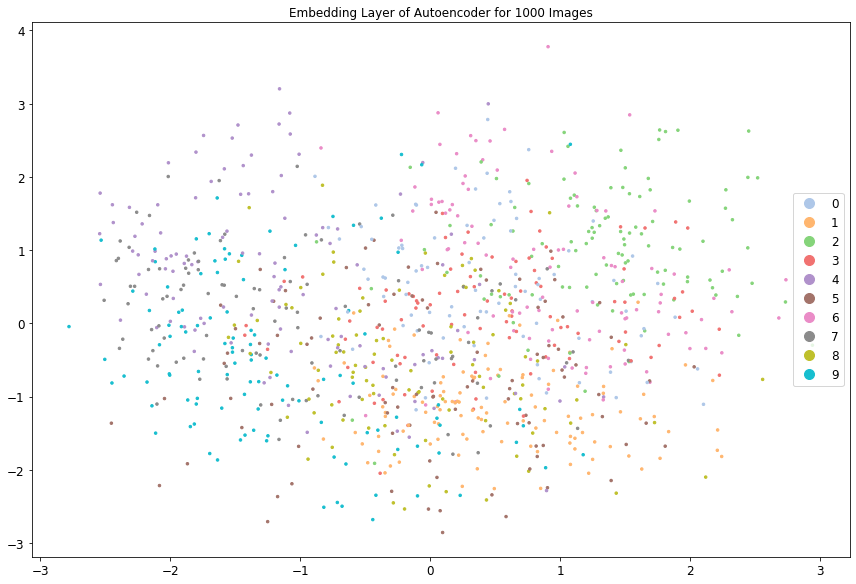

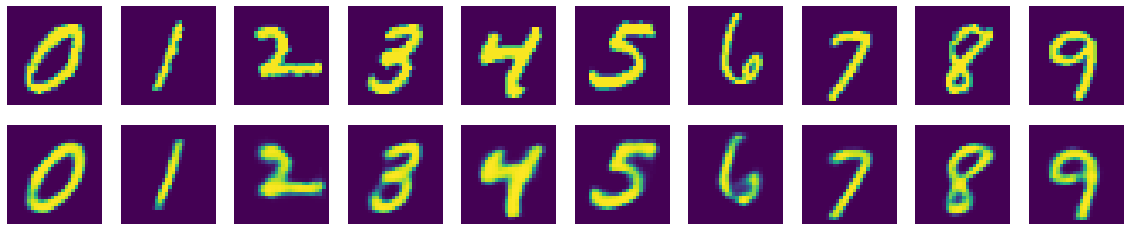

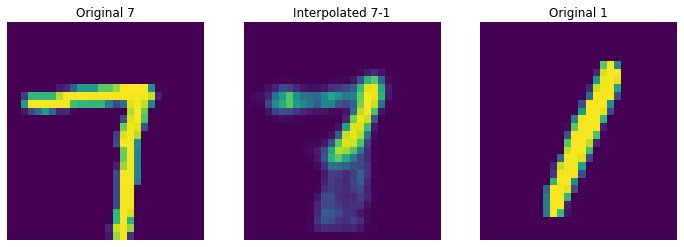

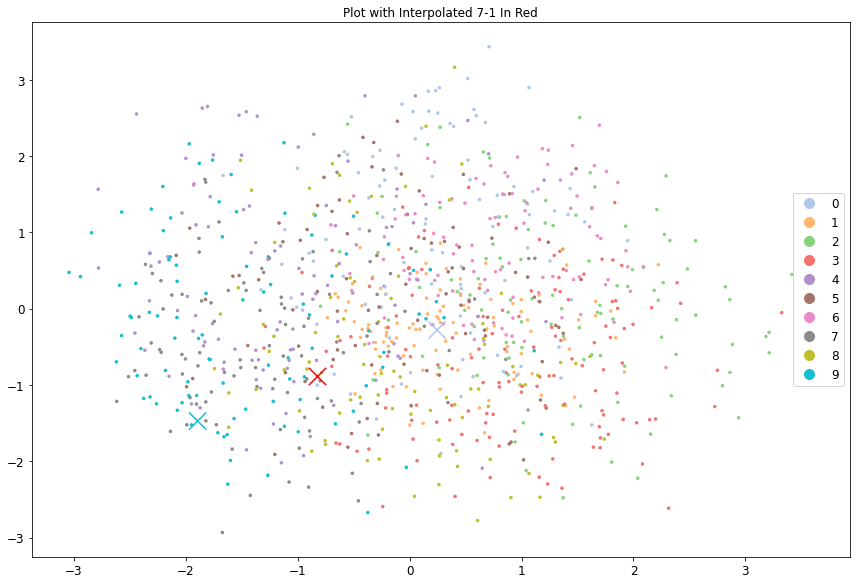

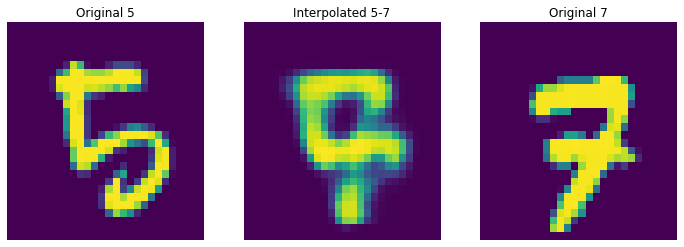

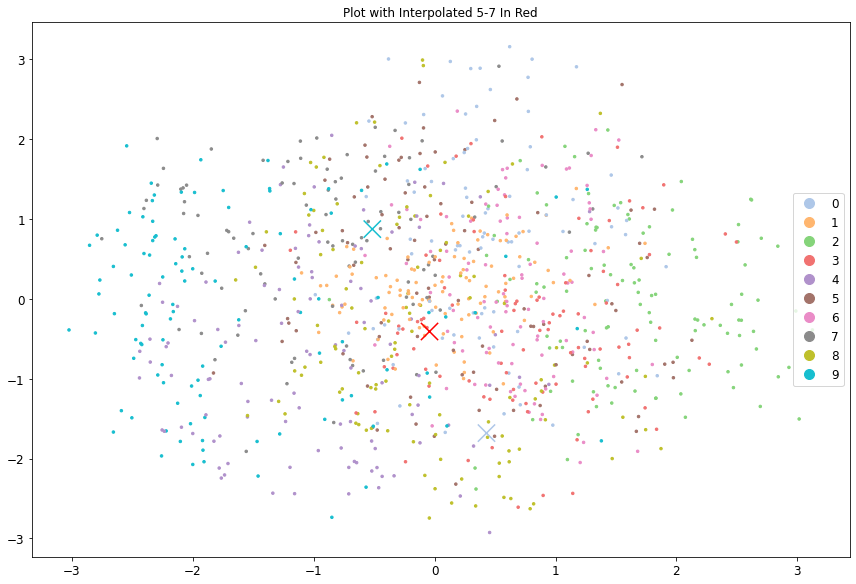

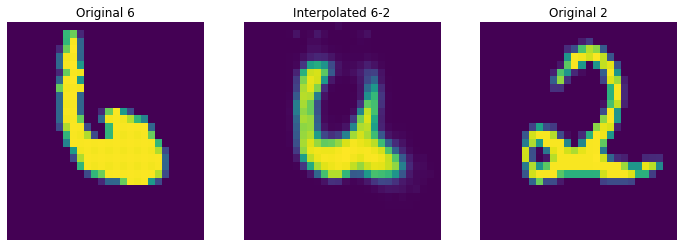

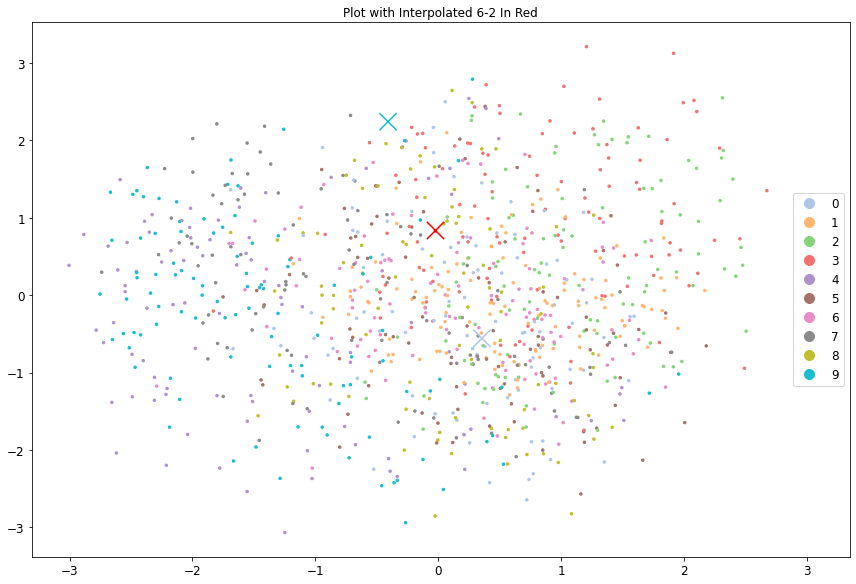

In [ ]:
model = torch.load('/content/drive/MyDrive/ColabNotebooks/vae.pt')
model = model.to("cpu")

display_1000(model, out_size = 20)
display_10(model)

for i in range(3):
  interpolate(model)

**Question 4.1.1:** *How does the VAE’s latent space compare to the latent space of your previous autoencoder? Do the generated images have more clarity? Is this most noticeable between or within classes?*

**Answer:** 

**Question 4.1.2:** *In what situations would a VAE be more useful than a vanilla autoencoder, and when would you prefer a vanilla autoencoder to a VAE?*

**Answer:** 

**Question 4.1.3:** *The distance between embeddings in your first autoencoder provided some measure of the similarity between digits. To what extent is this preserved, or improved, by the VAE?*

**Answer:** 


### 4.2 GANs

In [ ]:
!python code/GAN.py

Epoch 0: total discriminator loss 363.56268310546875 // total generator loss 384.6589050292969
Epoch 1: total discriminator loss 331.792724609375 // total generator loss 505.4214172363281
Epoch 2: total discriminator loss 277.65972900390625 // total generator loss 516.1083374023438
Epoch 3: total discriminator loss 238.49008178710938 // total generator loss 586.5157470703125
Epoch 4: total discriminator loss 260.5365295410156 // total generator loss 631.5301513671875
Epoch 5: total discriminator loss 262.12811279296875 // total generator loss 614.7127685546875
Epoch 6: total discriminator loss 281.1453857421875 // total generator loss 654.4589233398438
Epoch 7: total discriminator loss 329.0014343261719 // total generator loss 804.0660400390625
Epoch 8: total discriminator loss 253.5775604248047 // total generator loss 682.4847412109375
Epoch 9: total discriminator loss 280.1451416015625 // total generator loss 623.0554809570312
Epoch 10: total discriminator loss 298.0479736328125 // t

**Question 4.2.1:** *Which generates more realistic images: your GAN, or your VAE? Why do you think this
is?*

**Answer:** 

**Question 4.2.2:** *Does your GAN appear to generate all digits in equal number, or has it specialized in a smaller number of digits? If so, why might this be?*

**Answer:** 


## 5 Information Theory

### 5.1 Simple Distribution

In [31]:
import numpy as np
import time
from sklearn.neighbors import KernelDensity
from scipy.stats import entropy
import cv2

samples_unif = np.random.uniform(low = -0.5, high = 0.5, size = (1000, 3))
samples_normal = np.random.multivariate_normal((0, 0, 0), np.identity(3), 1000)

space = np.linspace(-1, 1, 10)
random_space_samples = np.dstack(np.meshgrid(space, space, space)).reshape(-1, 3)
shifted_space_samples = random_space_samples - random_space_samples.min()

In [32]:
begin = time.perf_counter()

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samples_unif)
probs_unif = np.exp(kde.score_samples(random_space_samples))

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samples_normal)
probs_normal = np.exp(kde.score_samples(random_space_samples))

dist = entropy(probs_unif, probs_normal)

print(f"KL Divergence: dist = {dist} && time = {time.perf_counter() - begin}")

KL Divergence: dist = 0.23797023363454528 && time = 0.18468535799911479


In [34]:
def img_to_sig(probs, coords):
    return np.float32(np.hstack((probs[:, np.newaxis], coords)))

begin = time.perf_counter()

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samples_unif)
probs_unif = np.exp(kde.score_samples(random_space_samples))
sig_unif = img_to_sig(probs_unif, random_space_samples)

kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samples_normal)
probs_normal = np.exp(kde.score_samples(random_space_samples))
sig_normal = img_to_sig(probs_normal, random_space_samples)

dist, _, flow = cv2.EMD(sig_unif, sig_normal, cv2.DIST_L2)

print(f"EMD: dist = {dist} && time = {time.perf_counter() - begin}")

EMD: dist = 0.010130421258509159 && time = 4.174085909995483


In [35]:
begin = time.perf_counter()

dist = mmd(samples_unif, samples_normal, kernel_fn = kernel)

print(f"MMD: dist = {dist} && time = {time.perf_counter() - begin}")

MMD: dist = 0.32702475745360904 && time = 0.09701418899931014


**Question 5.1.1:** *Based on the above measures alone, which divergence seems most accurate?*

**Answer:** 


### 5.2 MNIST Sample Distributions

### 5.3 The GAN Distribution

**Question 5.3.1:** *Which divergence or distance showed the greatest discrepancy between the comparison between real MNIST data and the comparison with the GAN?*

**Answer:** 

**Question 5.3.2:** *Which of these information measures would you recommend for judging a GAN’s output? Why?*

**Answer:** 

**Question 5.3.3:** *How do the runtimes of these measures compare?*

**Answer:** 
